In [1]:
##################
## Load Imports ##
##################
import math
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np

import plotting_helpers
%matplotlib inline
%load_ext autoreload
%autoreload 2
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Set the random seed for PyTorch
seed = torch.manual_seed(1)


# 2 Bayesian Logistic Regression

In this exercise, we will consider Bayesian logistic regression.

Exercises:
1. Complete the implementation of MAP estimation (Section 2.3)
2. Use the MAP estimation code to compute the Laplace Approximation (Section 2.4)
3. Implement the evidence lower bound (ELBO) for variational inference (Section 2.5)
4. **Bonus**: Derive and implement the reparameterization trick gradients for the expected log-likelihood (Section 2.6)

## 2.1 Preparing Data

We first load imports and generate a 2D synthetic dataset with two different classes. Data is taken from Kevin Murphy's Machine Learning: a Probabilistic Perspective

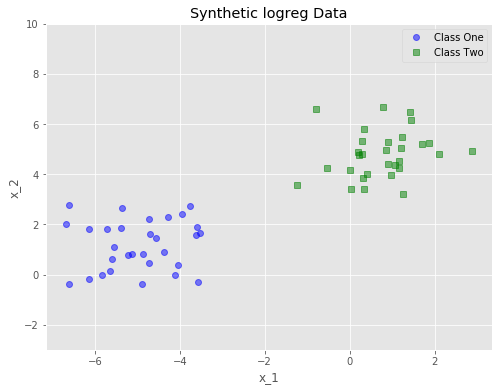

In [2]:
def logreg_synthetic_data(N=60, std1=1, std2=1.1):
    ''' Generate a binary classification dataset where the features for the two classes are
        sampled from different 2-dimensional Gaussians.
    '''
    mid_index = math.floor(N/2)
    
#   define different mean vectors for the two different classes.
    mu1 = torch.stack([torch.ones(mid_index), torch.ones(N-mid_index)*5],dim=1)
    mu2 = torch.stack([torch.ones(mid_index)*-5, torch.ones(N-mid_index)], dim=1)

#   sample features from normal distributions.
    X = torch.cat([
        torch.normal(mean=mu1, std=std1),
        torch.normal(mean=mu2, std=std2)])
    
#   class labels are in the set {0,1}.
    y = torch.ones(N)
    y[mid_index:N] = y[mid_index:N] - 1

    return X, y

X, y  = logreg_synthetic_data()

# plot the data set.
fig, ax = plotting_helpers.plot_logreg_data(X.detach().numpy(), y.detach().numpy())

## 2.2 Model Specification

The logistic regression model assumes that the outputs y are distributed as

$$y|\theta \sim Bernoulli(\sigma(\theta^\top x))$$

where $\sigma(z) = \frac{1}{1 + \exp(-z)}$ is the logistic function. The probability $p(y=1) = \sigma(\theta^\top x)$ is a linear function of the inputs $x$ passed through a "squish" function --- the logistic function $\sigma(z)$ in this case --- whose range is the interval $[0,1]$.

### 2.2.1 Specifying the Likelihood

The likelihood of the model is then given by

$$p(\mathcal{D} | \theta)  = \prod_{n=1}^N Bernoulli(y_i | \sigma(\theta^\top x_i))$$
$$p(\mathcal{D} | \theta)  = \prod_{n=1}^N y_i \sigma(\theta^\top x_i) + (1 - y_i) (1 - \sigma(\theta^\top x_i))$$

### 2.2.2 Specifying the Prior

The typical choice of prior is also a Gaussian,

$$p(\theta) = \mathcal{N}(\theta | 0, \lambda^{-1} \boldsymbol{I}),$$

where $\lambda$ is the prior precision. This prior is non-conjugate to the Gaussian likelihood, meaning that the posterior cannot be written easily in closed-form.

In [3]:
lam = 0.01 # Prior precision

mu_prior = torch.zeros(2) # Prior Mean
Sigma_prior = torch.eye(2) / lam
prior_distribution = MultivariateNormal(mu_prior, covariance_matrix=Sigma_prior)

### Visualizing the Prior and Posterior Distributions

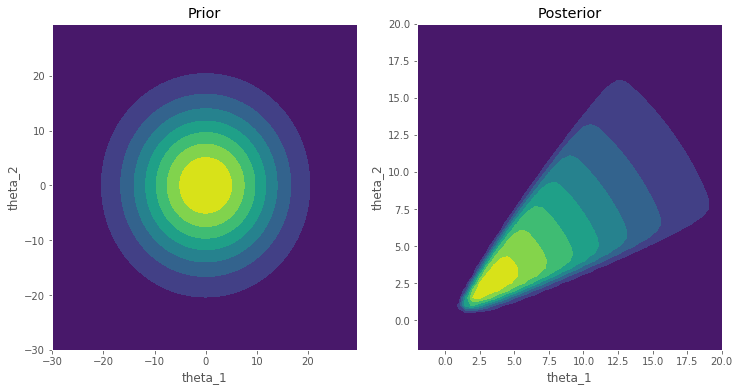

In [4]:
fig, ax1, ax2 = plotting_helpers.plot_logreg_prior_posterior(X, y, lam)

## 2.3 MAP Estimation (Exercise 1)

Recall that MAP estimation computes the maximum of the joint distribution 

$$P(\mathcal{D}, \theta) = p(\mathcal{D|\theta)} * p(\theta)$$.

This is achieved minimizing the sum of the negative log-likelihood and the negative log-prior (the MAP objective)

$$ \theta_{MAP} = argmin_{\theta} \big\{ - \sum_{i=1}^{N} \left[ y_i \log \sigma(\theta^\top x_i) + (1 - y_i)  \log(1 - \sigma(\theta^\top x_i)) \right] - \log p(\theta) \big\}$$

In the following, we provide a training loop for minimizing the MAP objective. This loop takes a loss function and a update function as parameters. 

### Exercise 1:
* Complete the implementation of ```log_prior``` by implementing the gradient of the negative log-prior.
* Complete the ```gradient_descent``` function by filling in the update step.
* **Hint**: Remember that the multivariate Gaussian density is

$$ p(x) = \mathcal{N}(x|\mu, \Sigma) = \frac{1}{(|2\pi \Sigma|)^{\frac{1}{2}}} \exp\left(-\frac{1}{2} (x - \mu)^\top \Sigma^{-1} (x - \mu)\right) $$

In [5]:
### SOLUTIONS BEGIN ###
def gradient_descent(lam, alpha, theta, g):
    theta = theta - alpha * g
    return theta


def log_prior(lam, theta):
    nlp = prior_distribution.log_prob(theta)
    
    g = theta * lam
    return nlp, g
### SOLUTIONS END ###

In [6]:
def log_likelihood(X, y, theta):
    ''' Computes and returns the value, gradient, and Hessian of the negative log-likelihood of the data
        (X,y) evaluated at theta.
        Parameters:
            X: dataset features
            y: dataset labels
    '''
    (N, _) = X.size()
    logits = torch.mv(X, theta)
    probs = torch.sigmoid(logits).clamp(min=1e-6, max=1-1e-6)
    nll = -1 * torch.sum(y * torch.log(probs) + (1 - y) * torch.log(1 - probs))

    g = torch.mv(X.t(), (probs - y))
    H = torch.mm(torch.mm(X.t(), torch.diag((probs * (1 - probs)))), X)

    return nll, g, H

    

def train(lam, max_iters, alpha, X, y, theta):
    ''' Basic training loop for MAP estimation.
        Parameters:
            lam: precision of the prior distribution
            max_iters: the number of iterations of gradient descent to run
            alpha: the gradient descent step size
            X: dataset features
            y: dataset labels
            theta: an initial value for the model parameters
    ''' 
    for i in range(max_iters):
        # gradient and Hessian of the negative log-likelihood
        nll, g_nll, H_nll = log_likelihood(X, y, theta)
        # gradient of the negative log-prior
        nlp, g_prior = log_prior(lam, theta)
        
        g = g_nll + g_prior
        
        theta = gradient_descent(lam, alpha, theta, g)
    return theta


# Compute the MAP Estimate
max_iters = 1000
alpha = 1
theta = torch.tensor([0,0], requires_grad=True, dtype=torch.float)
theta_map = train(lam, max_iters, alpha, X, y, theta)

### Visualizing the MAP Solution

The MAP estimate is: [2.984286  2.2597144]


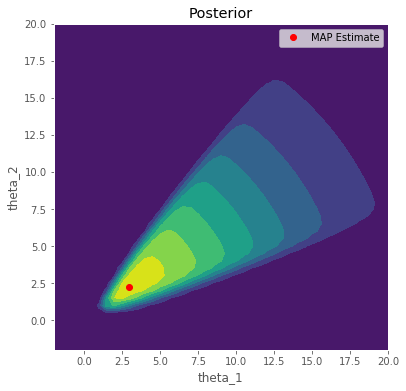

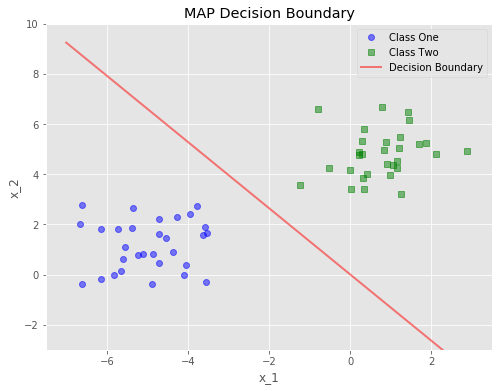

In [7]:
# Plot the MAP estimate
fig, ax1, _ = plotting_helpers.plot_logreg_prior_posterior(X, y, lam, plot_prior=False)
ax1.plot(theta_map[0].detach().numpy(), theta_map[1].detach().numpy(), 'ro', label='MAP Estimate')
ax1.legend()

fig, ax2 = plotting_helpers.plot_logreg_data(X.numpy(), y.numpy())
plotting_helpers.plot_map_boundary(ax2, theta_map.detach().numpy())
ax2.set_title('MAP Decision Boundary')
print('The MAP estimate is:', theta_map.detach().numpy())

## 2.4 Computing the Laplace Approximation (Exercise 2)

We now consider computing the Laplace Approximation to the posterior distribution for the synthetic logistic regression problem. This is easy to do since we have already found MAP estimate of our model parameters, $\theta_{MAP}$, using gradient descent.

Recall that the Laplace approximation is found by a second order Taylor series approximation of the log-posterior distribution at the MAP estimate:

$$ \log p(\theta | \mathcal{D}) \approx \log p(\theta_{MAP} | \mathcal{D}) + (\theta - \theta_{MAP})^\top \nabla_{\theta} \log p(\theta_{MAP} | \mathcal{D}) +  (\theta - \theta_{MAP})^\top \nabla_{\theta^2}^2 \log p(\theta_{MAP} | \mathcal{D})(\theta - \theta_{MAP}) $$


### Exercise 2:
* Complete the implementation of ```compute_laplace_approximation``` by filling in the computations for the mean and covariance of the approximation.
* HINT: Remember that ```log_likelihood``` also computes the Hessian of $- \log p(\mathcal{D}|\theta)$.

In [21]:
### SOLUTIONS BEGIN ###
def compute_laplace_approximation(lam, X, y, theta_map):

    mu = theta_map
    _, _, H_map = log_likelihood(X, y, mu)
    prior_precision = torch.eye(2) * lam
    Sigma = torch.inverse(prior_precision + H_map)

    return mu, Sigma
### SOLUTIONS END ###


mu_la, Sigma_la = compute_laplace_approximation(lam, X, y, theta_map)
print('The Laplace Approximation is: \n mean: \n', mu_la.detach().numpy(), '\n covariance: \n', Sigma_la.detach().numpy())

The Laplace Approximation is: 
 mean: 
 [2.984286  2.2597144] 
 covariance: 
 [[10.052417   6.395839 ]
 [ 6.3958397  7.8748765]]


### Visualizing the Laplace Approximation

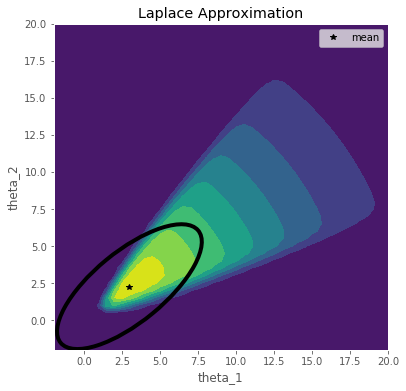

In [22]:
fig, ax1, _ = plotting_helpers.plot_logreg_prior_posterior(X, y, lam, plot_prior=False)
ellipse = plotting_helpers.plot_cov_ellipse(ax1, mu_la.detach().numpy(), Sigma_la.detach().numpy())
ax1.legend()
t = ax1.set_title('Laplace Approximation')

## 2.4.1 Issues with the Laplace Approximation

The mean of the Laplace Approximation is the **mode** of the posterior distribution, rather than the **mean**. This means that the Laplace Approximation can place significant probability mass on poor model parameters for skewed distribution, like the posterior above. We now move on to better methods for appoximating the posterior.


## 2.5 Variational Inference (Exercise 3)

### 2.5.1 The Evidence Lower Bound

Variational Inference (VI) optimizes the evidence lower bound (ELBO) instead of the MAP objective. Recall that the ELBO is given by

$$ \mathcal{L}_{ELBO} = \mathbb{E_q \left[ \log p(\mathcal{D} | \theta) \right]} - D_{KL}(q(\theta)||p(\theta))$$

where $q(\theta) = \mathcal{N}(\theta | \mu, \Sigma)$ is the variational approximation to the posterior distribution and $D_{KL}(q(\theta)||p(\theta))$ is the KL divergence between $q$ and the prior distribution. Recall that the ELBO is a lower bound on the marginal likelihood $p(\mathcal{D})$ and that maximizing the ELBO is equivalent to minimizing $D_{KL}(q||p(\theta | \mathcal{D}))$.

We will consider minimizing the negative ELBO $- \mathcal{L}_{ELBO}$ for consistency with the MAP estimation code above. In the VI code below, we use with the Cholesky factor $L$ of the covariance:

$$\Sigma = L L^\top.$$

Using the factor $L$ insures that $\Sigma$ remains positive definite (since only symmetric, positive definite matrices have a Cholesky factorization) and is numerically convenient.

### Exercise 3:
* Complete the implementations of ```sample_model```, ```expected_log_likelihood``` and ```elbo``` by filling in the missing computations.
* Compute the variational approximation to the posterior by minimizing the negative elbo (see ```compute_variational_approximation```)
* **HINTS**:
    * The implementation of $D_{KL}(q(\theta)||p(\theta))$ and its gradients is already provided.
    * The gradients of $\mathbb{E_q \left[ p(\mathcal{D} | \theta) \right]}$ can be obtained using the ```autograd_estimator``` function, which uses PyTorch's automatic differentiation to compute the reparameterization trick gradients.


### Provided Utilities

In [10]:
def kl_divergence(lam, mu, L):
    ''' Computes KL(q||p): the reverse KL divergence between a multivariate Gaussian distribution q 
        and p, a multivariate gaussian with mean 0 and covariance I / lam.
        Parameters:
            lam: the precision of the prior distribution
            mu: the mean of distribution q
            L: the (lower triangular) Cholesky factor of q's covariance (recall Sigma = LL^\top) 
    '''
    prior_prec = torch.ones_like(mu) * lam
    Sigma = torch.mm(L, L.t())
    Sigma_det = torch.log(torch.diag(L)).sum().mul(2)
    D = mu.size()[0]
    ld = torch.log(1/prior_prec).sum() - Sigma_det
    kl = torch.trace(Sigma.mul(prior_prec)) + ld + torch.dot(mu.mul(prior_prec), mu) - D
    kl = kl.div(2)
    
    mu_grad = mu * lam
    L_grad = torch.mm(torch.eye(mu.size()[0]) * lam, L + L.t()) / 2 - torch.inverse(L)
    
    return kl, mu_grad, L_grad


def autograd_estimator(lam, nll, epsilon, g, H, mu, L):
    ''' Computes the gradient of nll with respect to mu and L using PyTorch's built-in automatic
        differentiation. This function assumes that a nll was computed using theta_s,
        a parameter vector sampled from q(theta) = N(theta|u, LL').
        Only the nll, mu and L arguments are required; the other arguments are
        required by different gradient estimators and are kept to retain a unified function signature.
        Parameters:
            lam: the precision of the prior distribution
            nll: the negative log-likelihood
            epsilon: the (standard normal) noise vector used to compute theta_s with the 
                reparameterization trick.
    '''
    
    mu_grad = torch.autograd.grad(nll, mu, retain_graph=True)[0]
    L_grad = torch.autograd.grad(nll, L, retain_graph=True)[0]

    return mu_grad, L_grad

### ELBO Computations (Solutions)

In [11]:
### SOLUTIONS BEGIN ###
def sample_model(mu, L):
    ''' Samples a model parameter vector (theta_s) from the Gaussian distribution defined as
        N(theta|mu, LL')
        Paramters:
            mu: the mean of the distribution to sample from.
            L: the lower triangular Cholesky factor of the distribution's covariance.
    '''
    epsilon = torch.normal(mean=torch.zeros_like(mu), std=1)
    theta_s = torch.mv(L, epsilon) + mu

    return theta_s, epsilon

def expected_log_likehood(lam, X, y, mu, L, num_samples=50, gradient_estimator=autograd_estimator):
    ''' Approximates the value and gradients (for both mu and L) of the expectation of the negative log-likelihood 
        under the variational distribution q using Monte-carlo integration.
        Parameters:
            lam: precision of the prior distribution
            X: dataset features
            y: dataset labels
            mu: the mean of q
            L: the lower triangular Cholesky factor of q's covariance.
            num_samples: the number of samples used to estimate the integral
            gradient_estimator: the function used to compute the gradient of the negative log-likelihood
                with respect to mu and L. 
    ''' 
    nll_hat = 0
    mu_grad_hat = torch.zeros_like(mu)
    L_grad_hat = torch.zeros_like(L)

    for s in range(num_samples):
        theta_s, epsilon = sample_model(mu, L)
        nll, g, H = log_likelihood(X, y, theta_s)
        nll_hat = nll_hat + (nll / num_samples)

        mu_grad, L_grad = gradient_estimator(lam, nll, epsilon, g, H, mu, L)

        nll_hat = nll_hat + (nll / num_samples)
        mu_grad_hat = mu_grad_hat + (mu_grad / num_samples)
        L_grad_hat = L_grad_hat + (L_grad / num_samples)

    return nll, mu_grad_hat, L_grad_hat

def elbo(lam, X, y, mu, L, num_samples=10, estimator=autograd_estimator):
    ''' Computes and returns a stochastic estimates of the ELBO and the gradients of the
        ELBO with respect to mu and L.
        Parameters:
            lam: precision of the prior distribution
            X: dataset features
            y: dataset labels
            mu: the mean of q
            L: the lower triangular Cholesky factor of q's covariance.
            num_samples: the number of samples used to estimate the integral
            gradient_estimator: the function used to compute the gradient of the negative log-likelihood
                with respect to mu and L. 
    ''' 
    nll_hat, nll_mu_grad, nll_L_grad = expected_log_likehood(lam, X, y, mu, L, num_samples, estimator)
    kl, kl_mu_grad, kl_L_grad = kl_divergence(lam, mu, L)

    elbo = nll_hat + kl

    mu_grad_hat = nll_mu_grad + kl_mu_grad
    L_grad_hat = nll_L_grad + kl_L_grad

    return elbo, mu_grad_hat, L_grad_hat
### SOLUTIONS END ###

### Compute the Variational Approximation

In [12]:
### Variational Inference Training Loop ###
def compute_variational_approximation(lam, max_iters, alpha, num_samples, X, y, mu, L, estimator):
    ''' Basic training loop for variational inference
    '''
    for i in range(max_iters):
        negative_elbo, mu_grad, L_grad = elbo(lam, X, y,  mu, L, num_samples, estimator=estimator)
        mu = mu - alpha * mu_grad
        L = L - alpha * L_grad

    return mu, L

# Initial model
mu = torch.tensor([0,0], requires_grad=True, dtype=torch.float)
Sigma = torch.eye(2, requires_grad=True) / lam
# Compute the Cholesky decomposition of the covariance
L = torch.potrf(Sigma, upper=False)

max_iters = 200
num_samples = 50
alpha = 0.1

mu_vi, L_vi = compute_variational_approximation(lam, max_iters, alpha, num_samples, X, y, mu, L=L, estimator=autograd_estimator)
# Recover the covariance matrix from the Cholesky decomposition.
Sigma_vi = torch.mm(L_vi, L_vi.t())
print('The Variational Approximation is: \n mean: \n', mu_vi.detach().numpy(), '\n covariance: \n', Sigma_vi.detach().numpy())


The Variational Approximation is: 
 mean: 
 [10.892218   7.8483853] 
 covariance: 
 [[8.922795  4.0938053]
 [4.0938053 6.0597982]]


### Plotting the Variational Approximation

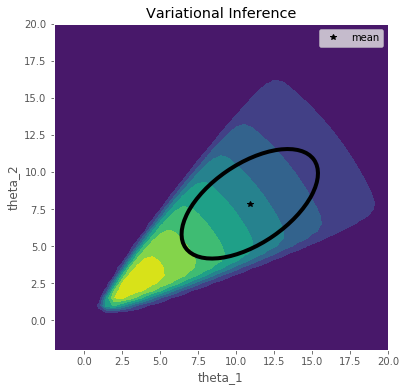

In [13]:
fig, ax1, _ = plotting_helpers.plot_logreg_prior_posterior(X, y, lam, plot_prior=False)
plotting_helpers.plot_cov_ellipse(ax1, mu_vi.detach().numpy(), Sigma_vi.detach().numpy())
ax1.legend()
t = ax1.set_title('Variational Inference')

### 2.5.2 Comparing VI and the Laplace Approximation

We now compare the VI and Laplace Approximation posteriors by sampling decision boundaries from each distribution.

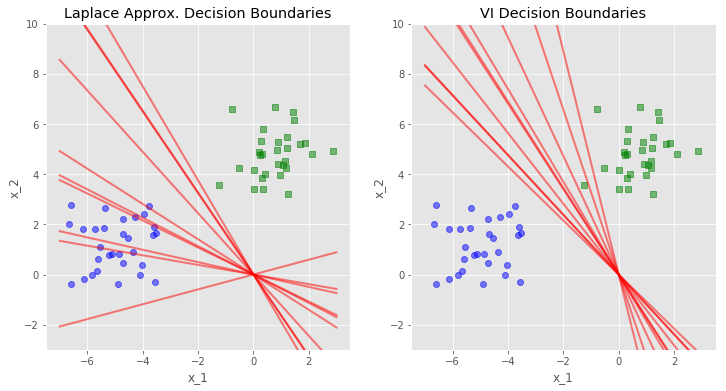

In [14]:
L_la = torch.potrf(Sigma_la, upper=False)
num_samples = 10

plotting_helpers.plot_la_vi_decision_boundaries(sample_model, num_samples, X, y, mu_la, L_la, mu_vi, L_vi)

## 2.6 Gradient Estimators (Optional Exercise)


### Optional Exercise:
* Manually implement the reparameterization trick gradients for the expected log-likelihood.
* HINT: Your implementation should only need the Gaussian noise vector ```epsilon``` and the gradient ```g```.

In [15]:
### SOLUTIONS BEGIN ###
def reparameterization_estimator(lam, nll, epsilon, g, H, mu, L):
    ''' Computes the gradient of nll with respect to mu and L using the reparameterization trick.
        This function is a "manual" implementation of autograd_estimator, which uses PyTorch's automatic
        differentiation. This function assumes that a nll was computed using theta_s,
        a parameter vector sampled from q(theta) = N(theta|u, LL').
        Parameters:
            lam: the precision of the prior distribution
            nll: the negative log-likelihood
            epsilon: the (standard normal) noise vector used to compute theta_s with the 
                reparameterization trick.
    '''
    mu_grad = g
    L_grad = torch.ger(g, epsilon)

    return mu_grad, L_grad
### SOLUTIONS END ###

In [16]:
# Initial model
mu = torch.tensor([0,0], requires_grad=True, dtype=torch.float)
Sigma = torch.eye(2, requires_grad=True) / lam
# Compute the Cholesky decomposition of the covariance
L = torch.potrf(Sigma, upper=False)

mu, L = compute_variational_approximation(lam, max_iters, alpha, num_samples, X, y, mu, L=L, estimator=reparameterization_estimator)
# Recover the covariance matrix from the Cholesky decomposition.
Sigma = torch.mm(L, L.t())
print('The Variational Approximation is: \n mean: \n', mu.detach().numpy(), '\n covariance: \n', Sigma.detach().numpy())


The Variational Approximation is: 
 mean: 
 [11.796514  8.064797] 
 covariance: 
 [[11.760623  8.163848]
 [ 8.163848  9.954493]]


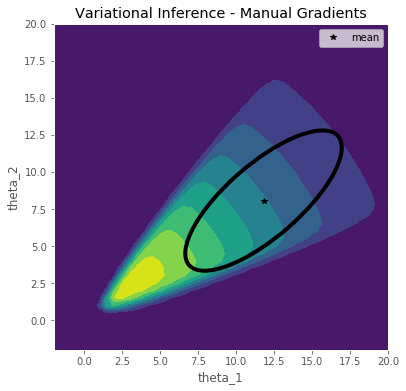

In [17]:
fig, ax1, _ = plotting_helpers.plot_logreg_prior_posterior(X, y, lam, plot_prior=False)
plotting_helpers.plot_cov_ellipse(ax1, mu.detach().numpy(), Sigma.detach().numpy())
ax1.legend()
t = ax1.set_title('Variational Inference - Manual Gradients')